In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('cleaned_data.csv').drop('geometry', axis=1)
df['geometry'] = df.apply(lambda x: Point((x.lon, x.lat)), axis=1)
df.drop(['category_name', 'lat', 'lon'], axis=1, inplace=True)
df

trending_date    channel_title    views  likes  dislikes  \
0       2017-11-13 18:30:00+00:00  Lokdhun Punjabi  1096327  33966       798   
1       2017-11-13 18:30:00+00:00          HJ NEWS   590101    735       904   
2       2017-11-13 18:30:00+00:00             TFPC   473988   2011       243   
3       2017-11-13 18:30:00+00:00      Eruma Saani  1242680  70353      1624   
4       2017-11-13 18:30:00+00:00       Filmylooks   464015    492       293   
...                           ...              ...      ...    ...       ...   
158695  2018-06-13 21:00:00+00:00    Портье Дрогба    70654   3806        87   
158696  2018-06-13 21:00:00+00:00     Pastime Time   129488   5893       164   
158697  2018-06-13 21:00:00+00:00           CaGArt    99163   4659       337   
158698  2018-06-13 21:00:00+00:00     DaisyxBTS 07   449611  24808        93   
158699  2018-06-13 21:00:00+00:00   Ксюша Лебедева    14225    793        39   

        comment_count  comments_disabled  ratings_disabled  \
0                 882              False             False   
1                   0               True             False   
2                 149              False             False   
3                2684              False             False   
4                  66              False             False   
...               ...                ...               ...   
158695            230              False             False   
158696            990              False             False   
158697            692              False             False   
158698            974              False             False   
158699            209              False             False   

                         state Country                         geometry  
0            Arunachal Pradesh      IN  POINT (93.61660071 27.10039878)  
1            Arunachal Pradesh      IN  POINT (93.61660071 27.10039878)  
2       Dadra And Nagar Haveli      IN   POINT (73.0166178 20.26657819)  
3                     Nagaland      IN   POINT (94.11657019 25.6669979)  
4             Himachal Pradesh      IN  POINT (77.16659704 31.10002545)  
...                        ...     ...                              ...  
158695                 Khakass      RU   POINT (91.22268998 53.8313253)  
158696               Volgograd      RU  POINT (45.42610551 50.01610598)  
158697                    Komi      RU  POINT (64.12325883 67.60828798)  
158698                 Khakass      RU   POINT (91.22268998 53.8313253)  
158699              Yaroslavl'      RU  POINT (38.33000118 57.52435569)  

[158700 rows x 11 columns]

In [5]:
df.Country.unique()

array(['IN', 'JP', 'KR', 'MX', 'RU'], dtype=object)

In [6]:
df.describe()

views         likes      dislikes  comment_count
count  1.587000e+05  1.587000e+05  1.587000e+05   1.587000e+05
mean   4.985449e+05  1.639375e+04  1.037249e+03   2.054403e+03
std    2.175226e+06  8.868757e+04  1.212607e+04   1.516866e+04
min    1.170000e+02  0.000000e+00  0.000000e+00   0.000000e+00
25%    3.509475e+04  4.270000e+02  2.900000e+01   6.700000e+01
50%    1.075105e+05  1.713000e+03  1.100000e+02   2.820000e+02
75%    3.281060e+05  6.858000e+03  4.300000e+02   1.013000e+03
max    1.254322e+08  5.150839e+06  1.545017e+06   1.142274e+06

In [7]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
numeric_df

views  likes  dislikes  comment_count
0       1096327  33966       798            882
1        590101    735       904              0
2        473988   2011       243            149
3       1242680  70353      1624           2684
4        464015    492       293             66
...         ...    ...       ...            ...
158695    70654   3806        87            230
158696   129488   5893       164            990
158697    99163   4659       337            692
158698   449611  24808        93            974
158699    14225    793        39            209

[158700 rows x 4 columns]

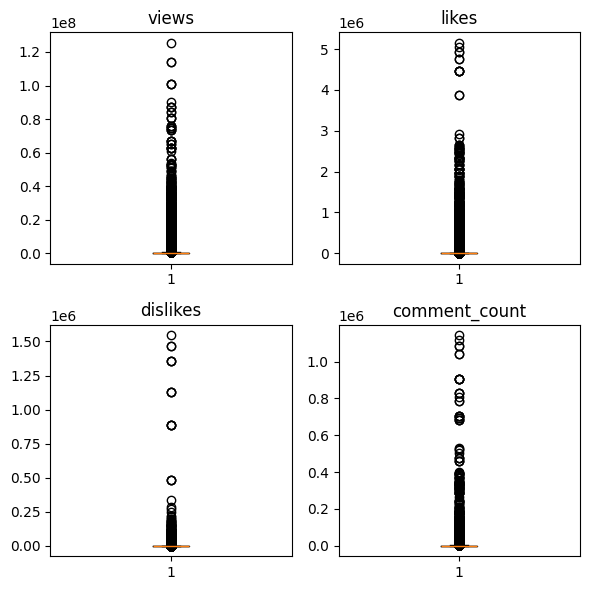

In [8]:
num_cols = 2
num_rows = len(numeric_df.columns) // num_cols + (1 if len(numeric_df.columns) % num_cols != 0 else 0)
plot_size = 3

fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*plot_size, num_rows*plot_size))

for i, item in enumerate(numeric_df.columns):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].boxplot(numeric_df[item])
    axs[row, col].set_title(item)

plt.tight_layout()
plt.show()

In [9]:
def get_bounds(ldf, column):
    q1 = ldf[column].quantile(0.25)
    q3 = ldf[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

In [10]:
def get_outlier_count(ldf, column):
    lower_bound, upper_bound = get_bounds(ldf, column)
    return len(ldf[(ldf[column] < lower_bound) | (ldf[column] > upper_bound)])

In [11]:
for item in numeric_df.columns:
    outliers = get_outlier_count(df, item)
    print(item, outliers, f"{outliers/len(df)*100:.2f}%")

views 18952 11.94%
likes 22606 14.24%
dislikes 22015 13.87%
comment_count 19580 12.34%


In [12]:
from shapely.geometry import Polygon, MultiPolygon

def shift_lon(geometry):
    if isinstance(geometry, Polygon):
        new_coords = [(lon + 360 if lon < 0 else lon, lat) for lon, lat in geometry.exterior.coords]
        return Polygon(new_coords)
    elif isinstance(geometry, MultiPolygon):
        new_polys = []
        for poly in geometry.geoms:
            new_coords = [(lon + 360 if lon < 0 else lon, lat) for lon, lat in poly.exterior.coords]
            new_polys.append(Polygon(new_coords))
        return MultiPolygon(new_polys)
    else:
        return geometry

In [13]:
from functools import reduce
def get_outlier_series(ldf):
    s = []
    for item in ldf.columns:
        lower_bound, upper_bound = get_bounds(ldf, item)
        s.append((ldf[item] < lower_bound) | (ldf[item] > upper_bound))
        
    return reduce(lambda x, y: x | y, s)

In [14]:
def get_map_stats(ll_df, mp, sz=(14, 8)):
    l = ['views', 'likes', 'dislikes', 'interactions', 'comment_count']
    #subplot for each column in l
    num_cols = 1
    num_rows = 5
    sx, sy = sz
    sy *= num_rows
    geo_df = gpd.GeoDataFrame(ll_df, geometry=ll_df.geometry.values)
    if mp == 'russia': geo_df.geometry = geo_df.geometry.apply(lambda geom: geom if geom.x >= 0 else Point(geom.x + 360, geom.y))
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(sx, sy))
    world = gpd.read_file(f'maps/{mp}.shp')
    if mp == 'russia': world['geometry'] = world['geometry'].apply(shift_lon);
    for ax, item in zip(axs.flatten(), l):
        base = world.plot(color='white', edgecolor='black', ax=ax)
        geo_df.plot(column=item, ax=base, legend=True, marker='o', cmap='Reds', markersize=50)
        ax.axis('off')
        ax.set_title(item)
        for x, y, label in zip(geo_df.geometry.x, geo_df.geometry.y, geo_df.index):
            ax.annotate(label, xy=(x, y), xytext=(3,3), textcoords="offset points", fontsize=8, color='black')
    plt.tight_layout()
    plt.show()

In [15]:
def get_stats(cdf, cname):
    c = cdf[cdf.Country == cname].drop(['Country'], axis=1)
    c_geo = c[['state', 'geometry']].drop_duplicates().set_index('state')
    numeric_c = c.select_dtypes(include=['float64', 'int64'])
    numeric_c['state'] = c['state']
    numeric_c['interactions'] = numeric_c['likes'] + numeric_c['dislikes']
    c_group = numeric_c.groupby('state').sum().join(c_geo)
    return c_group

In [16]:
mx = get_stats(df, 'MX')
mx

views     likes  dislikes  comment_count  \
state                                                               
Aguascalientes       400946594  19143454    838298        2585417   
Baja California      502544971  21074750    761727        2566760   
Baja California Sur  302223341  15272841    637104        2000055   
Campeche             441024680  21285515    824860        2502002   
Chiapas              454723177  22419383    743655        2912235   
Chihuahua            322999716  17554335    617679        2377178   
Coahuila             542928078  26487398   1115250        3536119   
Colima               397016340  17995881    746754        2122273   
Distrito Federal     454571115  20462667    949473        2423060   
Durango              459156433  22145133   1852184        3378366   
Guanajuato           448071154  19657335    783832        2524623   
Guerrero             433647316  18734610    829409        1946141   
Hidalgo              462919105  18967121    766772        2133782   
Jalisco              369810835  17196475   1075151        2477948   
Mexico               495091102  26259723    962973        3620627   
Michoacan            426525913  18308567    715134        2346199   
Morelos              414841322  16651505    861595        2177889   
Nayarit              426120438  19360071    712884        2456808   
Nuevo Leon           451977735  19545310    973512        2404499   
Oaxaca               419761569  20322610   1666339        2789008   
Puebla               355287738  17217044    636782        1924868   
Queretaro            387242639  17351091    666230        1989803   
Quintana Roo         456919657  18784910    713897        1991644   
San Luis Potosi      470366848  18917247    746850        2424444   
Sinaloa              402629969  21840867   1017964        3102522   
Sonora               494684240  25278327    979440        3201425   
Tabasco              454955459  18940417    757365        2303803   
Tamaulipas           381099141  18145719    794153        2367123   
Tlaxcala             339114258  17240345    865806        2044680   
Veracruz             497722727  20342019   2302057        3125958   
Yucatan              422037356  20479008    827466        2544974   
Zacatecas            431239127  20380865    830115        2287816   

                     interactions                          geometry  
state                                                                
Aguascalientes           19981752  POINT (-102.2904135 21.87945992)  
Baja California          21836477  POINT (-116.0092603 30.76405113)  
Baja California Sur      15909945  POINT (-111.3516635 26.01333335)  
Campeche                 22110375  POINT (-91.82448019 18.65365928)  
Chiapas                  23163038  POINT (-92.63337447 16.74999697)  
Chihuahua                18172014  POINT (-105.6666358 26.93335472)  
Coahuila                 27602648  POINT (-100.8499789 28.32998781)  
Colima                   18742635  POINT (-103.8799748 18.92038129)  
Distrito Federal         21412140   POINT (-99.1309882 19.44244244)  
Durango                  23997317  POINT (-103.5000238 25.57005292)  
Guanajuato               20441167  POINT (-101.4999909 20.67001609)  
Guerrero                 19564019   POINT (-99.5000096 17.54997398)  
Hidalgo                  19733893  POINT (-98.73003076 20.17043418)  
Jalisco                  18271626  POINT (-104.3699966 19.77001935)  
Mexico                   27222696  POINT (-99.02998661 19.41001548)  
Michoacan                19023701   POINT (-100.569996 19.67997316)  
Morelos                  17513100  POINT (-99.23999964 18.92110476)  
Nayarit                  20072955  POINT (-105.2200481 21.81999758)  
Nuevo Leon               20518822   POINT (-99.83998885 25.1899986)  
Oaxaca                   21988949  POINT (-95.01999882 16.42999066)  
Puebla                   17853826  POINT (-98.44999618 18.90002077)  
Queretaro                18017321  POINT (-100.0000308 20.37998212) 

c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: maps/mexico.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


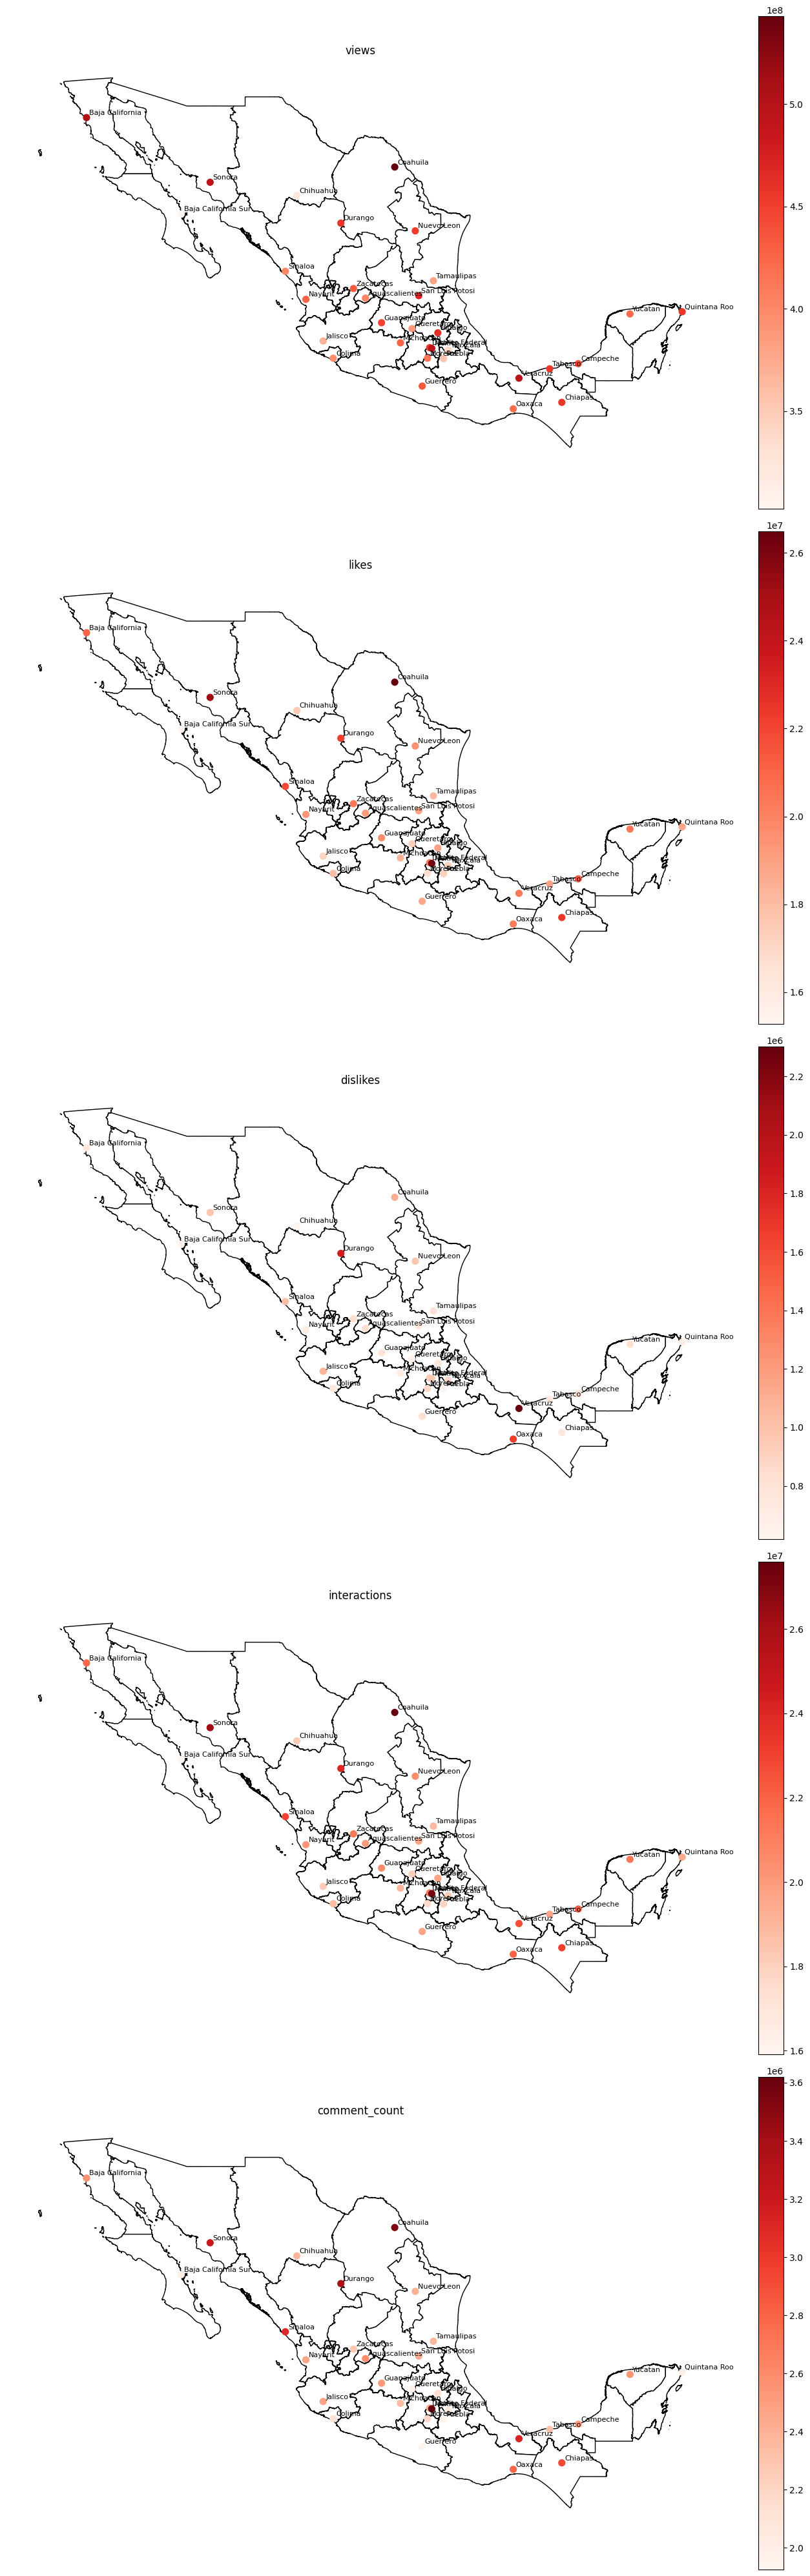

In [17]:
get_map_stats(mx, 'mexico')

In [18]:
kr = get_stats(df, 'KR')
kr

views     likes  dislikes  comment_count  \
state                                                               
Busan               1047847724  25547012   1074379        3921886   
Chungcheongbuk Do    894984111  26875777    947993        4687419   
Daegu                968105202  31546953    991137        5209128   
Daejeon              857005662  22534509    858788        4055460   
Gangwon Do          1167863258  37075100   1186519        5848097   
Gwangju             1031729483  29836154   1723514        5174019   
Gyeonggi Do          863126775  25439505    811842        4065622   
Gyeongsangnam Do     894830021  24325585    896245        4190837   
Inch'on Gwangyoksi   922330374  27240689    721917        3818585   
Jeju                 924367823  24700216    741693        4109909   
Jeollabuk Do         948374466  27202003   1909391        4872756   
Kwangju Gwangyoksi   861076125  24033829   1035698        3780699   
Seoul                866497784  25013368    778822        3805678   
Taegu Gwangyoksi     960447000  25582537    838314        3956762   
Ulsan               1387812700  42147096   4038140        8160095   

                    interactions                         geometry  
state                                                              
Busan                   26621391  POINT (129.0100476 35.09505292)  
Chungcheongbuk Do       27823770  POINT (127.6897147 36.93525067)  
Daegu                   32538090   POINT (129.211689 35.84275922)  
Daejeon                 23393297   POINT (127.425028 36.33554567)  
Gangwon Do              38261619  POINT (127.9396219 37.35514752)  
Gwangju                 31559668  POINT (127.7458353 34.73678021)  
Gyeonggi Do             26251347  POINT (126.8595328 37.34806785)  
Gyeongsangnam Do        25221830   POINT (128.583562 35.21910219)  
Inch'on Gwangyoksi      27962606  POINT (126.6422334 37.47614789)  
Jeju                    25441909  POINT (126.5219307 33.51013674)  
Jeollabuk Do            29111394  POINT (126.9454191 35.94097027)  
Kwangju Gwangyoksi      25069527   POINT (126.9104341 35.1709656)  
Seoul                   25792190    POINT (126.999731 37.5663491)  
Taegu Gwangyoksi        26420851  POINT (128.6069714 35.86678876)  
Ulsan                   46185236  POINT (129.3169539 35.54673077)

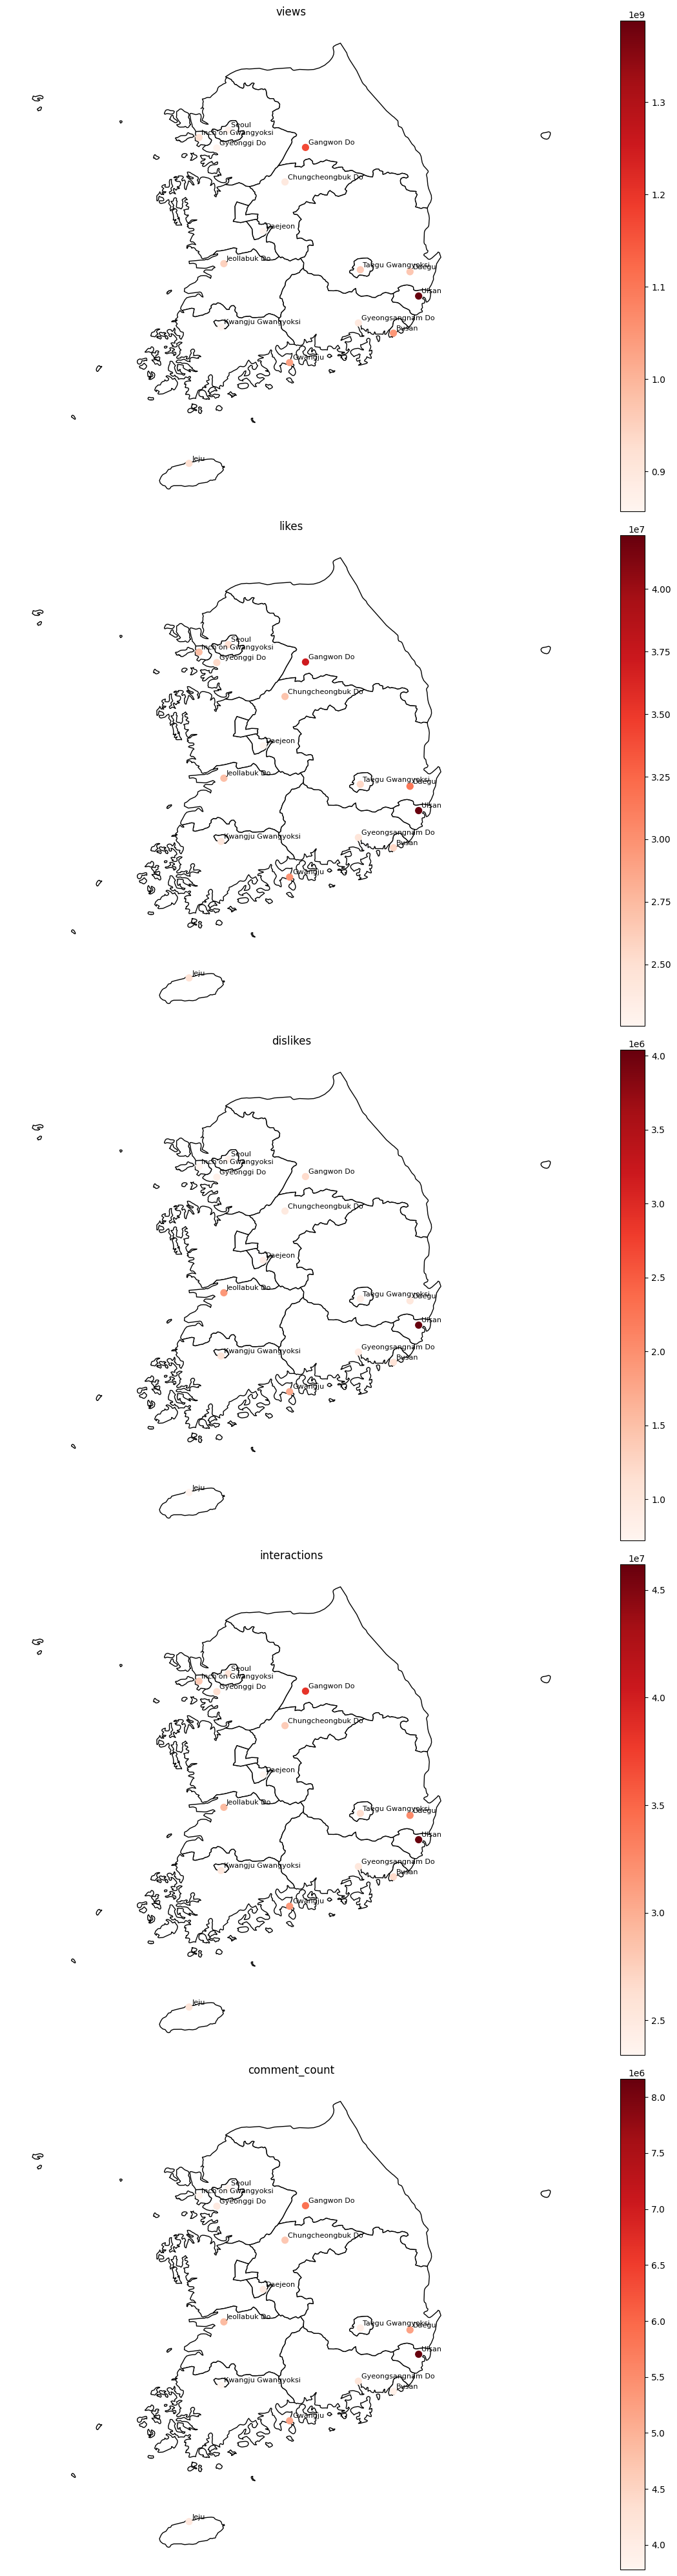

In [19]:
get_map_stats(kr, 'korea')

In [20]:
ind = get_stats(df, 'IN')
ind

views     likes  dislikes  comment_count  \
state                                                                   
Andaman And Nicobar     1324003358  34752288   1813854        3463495   
Andhra Pradesh          1379130612  39110273   1927018        4217969   
Arunachal Pradesh       1247061000  31227901   1610572        3011749   
Assam                   1059400199  25903777   1489094        2361979   
Bihar                   1146134928  28748481   2682915        2998089   
Chandigarh              1356259802  35411279   2074230        3459938   
Chhattisgarh            1107090610  28852455   2217407        2916755   
Dadra And Nagar Haveli  1099493019  28979040   1642360        2903397   
Delhi                   1213084397  31794392   1915650        3070170   
Goa                     1252134402  30180814   3142568        3454323   
Haryana                 1235048237  30807573   2043514        2835354   
Himachal Pradesh        1157709473  30158866   1493735        2763066   
Jammu And Kashmir       1111626446  27246706   1556286        3023651   
Jharkhand               1172589664  29647317   1676622        2655577   
Karnataka               1179908093  28580103   1495040        2485556   
Kerala                  1200559679  33596101   2968270        4258626   
Lakshadweep             1167783310  28686684   1505210        2696978   
Madhya Pradesh          1281509001  28854124   1859880        2723901   
Maharashtra              904971790  23013834   1220947        1979033   
Manipur                 1140880943  27699474   1544515        2500918   
Meghalaya               1113724888  28732613   1677553        2565306   
Mizoram                 1121987956  27156267   1675818        2588356   
Nagaland                1435398055  39595775   3214784        4239193   
Orissa                  1097532699  25773841   1504864        2699688   
Puducherry              1163657378  30180391   1545019        2678322   
Punjab                  1180348207  29103775   1591953        3023851   
Rajasthan               1095238383  31674541   1632553        3651940   
Sikkim                  1128673798  31303310   1647010        2735170   
Tamil Nadu              1161823867  26237155   1464375        2249538   
Tripura                 1240601589  29731053   1720857        2927741   
Uttar Pradesh           1245535014  30066583   2482521        3290105   
Uttaranchal             1271934290  30681623   1779202        2838944   
West Bengal             1250705229  35985007   1781773        3657436   

                        interactions                         geometry  
state                                                                  
Andaman And Nicobar         36566142  POINT (92.73598262 11.66702557)  
Andhra Pradesh              41037291   POINT (78.57002559 14.7504291)  
Arunachal Pradesh           32838473  POINT (93.61660071 27.10039878)  
Assam                       27392871   POINT (94.21666744 26.7499809)  
Bihar                       31431396   POINT (87.4799727 25.78541445)  
Chandigarh                  37485509  POINT (76.78000565 30.71999697)  
Chhattisgarh                31069862  POINT (82.15998734 22.09042035)  
Dadra And Nagar Haveli      30621400   POINT (73.0166178 20.26657819)  
Delhi                       33710042   POINT (77.23000403 28.6699929)  
Goa                         33323382    POINT (73.81800065 15.491997)  
Haryana                     32851087  POINT (77.01999101 28.45000633)  
Himachal Pradesh            31652601  POINT (77.16659704 31.10002545)  
Jammu And Kashmir           28802992  POINT (74.46665849 34.29995933)  
Jharkhand                   31323939  POINT (86.41998572 23.80039349)  
Karnataka                   30075143  POINT (76.91999711 12.57038129)  
Kerala                      36564371  POINT (76.56999263 8.900372741)  
Lakshadweep                 30191894  POINT (72.63686717 10.56257331)  
Madhya Pradesh              30714004  POINT (76.13001949 21.30039105)  
Maharashtra                 24234

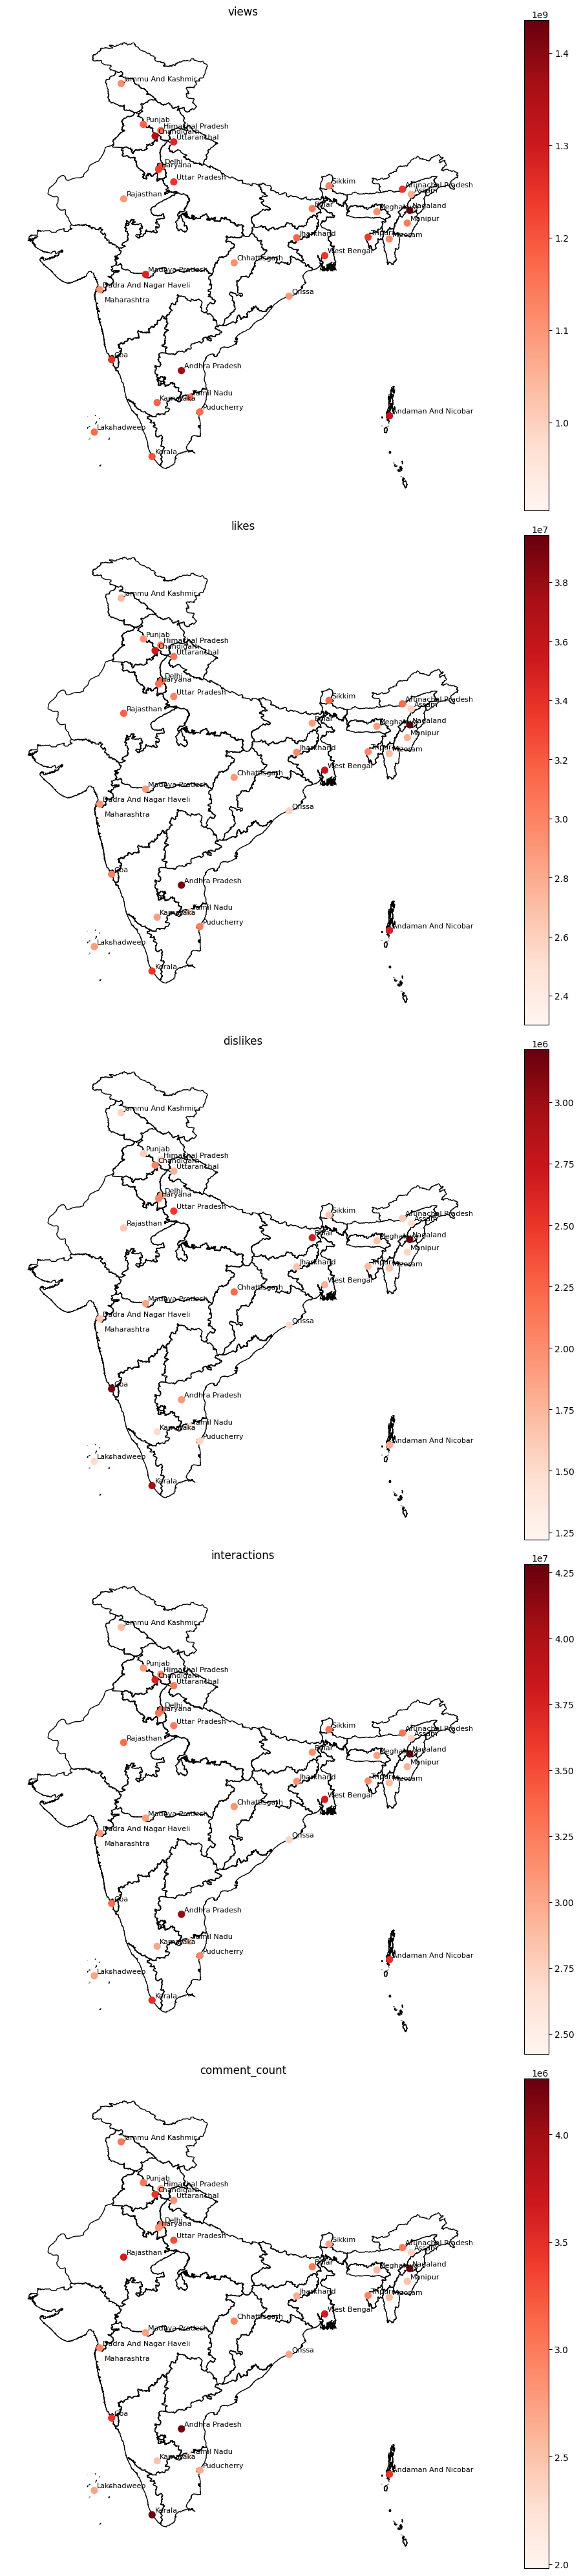

In [21]:
get_map_stats(ind, 'india')

In [22]:
ru = get_stats(df, 'RU')
ru

views    likes  dislikes  comment_count  interactions  \
state                                                                     
Adygey        100934612  4544431    519568         595562       5063999   
Aga Buryat    111940612  5262701    630669         656644       5893370   
Altay          73684867  3826612    517859         519111       4344471   
Amur          105882405  5359458    380315         778585       5739773   
Arkhangel'sk  115528688  6036295    589697         672397       6625992   
...                 ...      ...       ...            ...           ...   
Vologda        99591500  4304157    387927         796093       4692084   
Voronezh       87617152  4576799    556220         801890       5133019   
Yamal Nenets  111759574  6461329    631737        1298913       7093066   
Yaroslavl'    114077416  5010028    365290         560460       5375318   
Yevrey        103449044  7201505    717108        1075801       7918613   

                                     geometry  
state                                          
Adygey        POINT (40.12002112 44.60997601)  
Aga Buryat    POINT (114.5228182 51.10306805)  
Altay         POINT (85.18000972 52.53406598)  
Amur          POINT (129.6166772 49.75038576)  
Arkhangel'sk    POINT (54.420799 70.73144845)  
...                                       ...  
Vologda       POINT (40.11438839 59.46477989)  
Voronezh      POINT (42.08873816 51.36871075)  
Yamal Nenets  POINT (77.13331742 68.35038739)  
Yaroslavl'    POINT (38.33000118 57.52435569)  
Yevrey         POINT (131.083306 48.99999229)  

[89 rows x 6 columns]

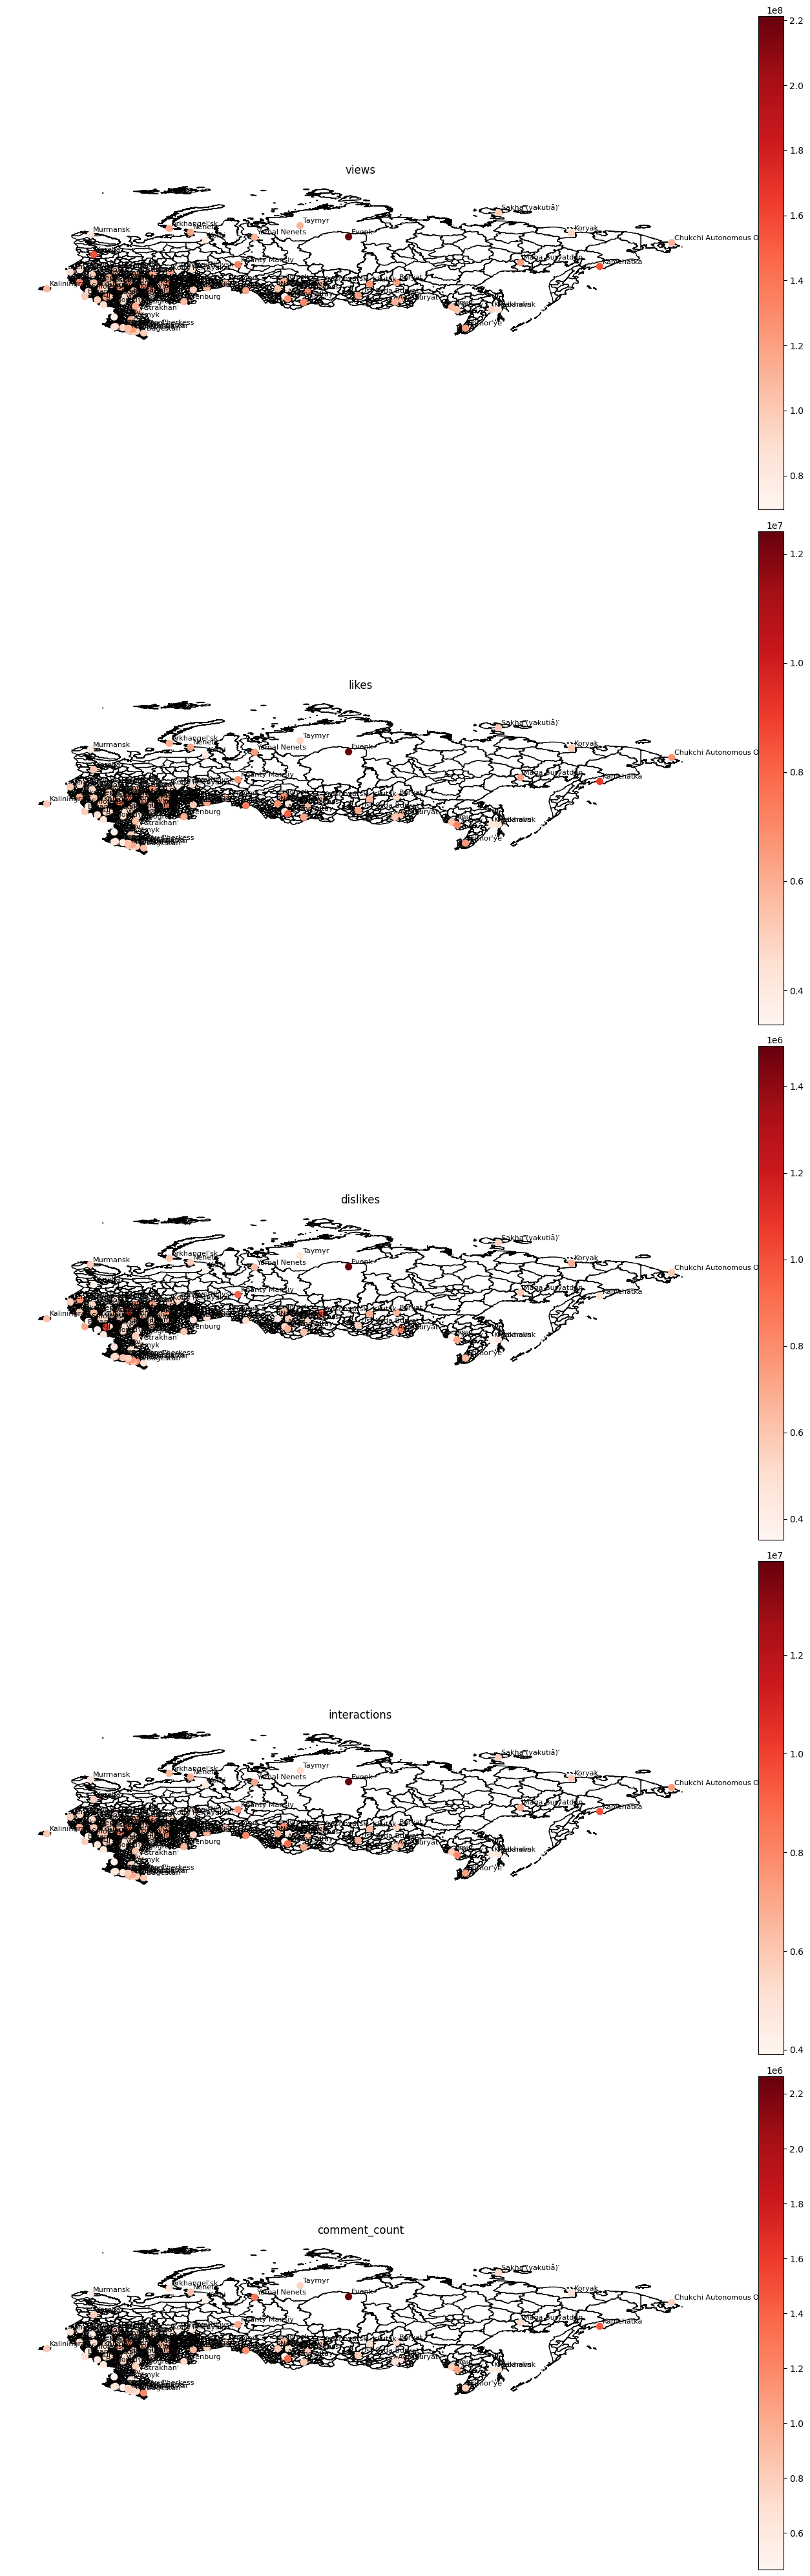

In [23]:
get_map_stats(ru, 'russia')

In [24]:
jp = get_stats(df, 'JP')
jp

views    likes  dislikes  comment_count  interactions  \
state                                                                 
Aichi      50898029  1054293     87011         127819       1141304   
Akita      52066207  3150065     48512         346939       3198577   
Aomori     51592249  1001893     58565         160244       1060458   
Ehime      28267087   993378     37951         143779       1031329   
Fukui      48001743  2676838     50270         382176       2727108   
Fukuoka    55347015  1447221     54449         180536       1501670   
Fukushima  33670735  1113706     72108         165022       1185814   
Gifu       42857283  2463746     62425         301682       2526171   
Gunma      69475934  1539711     59560         202501       1599271   
Hiroshima  57236274   696582     60960         120028        757542   
Hokkaido   60685023  2088625     98522         274745       2187147   
Hyogo      45096158   986938     45623         138415       1032561   
Ibaraki    49053485   914496     74009         119371        988505   
Ishikawa   71097059  1983288    131709         443188       2114997   
Iwate      52305424   931904     47354         130849        979258   
Kagawa     44517602  1140412     44998         176160       1185410   
Kagoshima  43330849  1152325     67317         147692       1219642   
Kanagawa   45828866  1512957     64883         199552       1577840   
Kochi      30852205  1213137     34898         149715       1248035   
Kumamoto   37948160  1031852     68521         164627       1100373   
Kyoto      28865780   658659     35426         111065        694085   
Mie        42024509  1017373     70303         127380       1087676   
Miyagi     39815802   636761     39264         103644        676025   
Miyazaki   25528843   596700     24580          96936        621280   
Nagano     51172357  1352828     60729         160503       1413557   
Nagasaki   56027154  2395034     72312         295275       2467346   
Niigata    28758776   555477     33660          94293        589137   
Oita       61995357  1840423     95196         235977       1935619   
Okayama    60410805  1506384     67037         186141       1573421   
Okinawa    68568407  3788392     92566         524084       3880958   
Osaka      60781572  2814252     77647         504663       2891899   
Saitama    61757774  1771807     51048         190613       1822855   
Shiga      28209020   703874     33853         110228        737727   
Shimane    48648221  1647320     79983         276102       1727303   
Shizuoka   27120370   525157     25556         110772        550713   
Tochigi    42912188  2155635     51811         288119       2207446   
Tokushima  34309689   932068     75957         135941       1008025   
Tokyo      32071996  1034440     38872         148365       1073312   
Tottori    40170242   729333     62916         151356        792249   
Toyama     45070359  1339333     37603         163949       1376936   
Wakayama   48418978  1042678     54019         137028       1096697   
Yamagata   50174638  1198068     58237         168941       1256305   
Yamaguchi  48286808  2760072     71530         432748       2831602   
Yamanashi  40675937   898061     48742         158091        946803   

                                  geometry  
state                                       
Aichi      POINT (136.9149914 35.15499758)  
Akita      POINT (140.0899914 39.70999086)  
Aomori     POINT (140.7100052 40.82503908)  
Ehime       POINT (132.765839 33.84554262)  
Fukui      POINT (136.2200468 36.07041974)  
Fukuoka    POINT (130.8200146 33.87039899)  
Fukushima  POINT (140.3799996 37.40997622)  
Gifu       POINT (136.7627526 35.42309491)  
Gunma      POINT (139.0726892 36.39269981)  
Hiroshima  POINT (132.5655928 34.25097007)  
Hokkaido   POINT (143.1700101 42.93041445)  
Hyogo      POINT (135.1699816 34.67998781)  
Ibaraki    POINT (140.4800451 36.37042727)  
Ishikawa   POINT (136.6400211 36.56000226)  
Iwate      POINT (141.13003

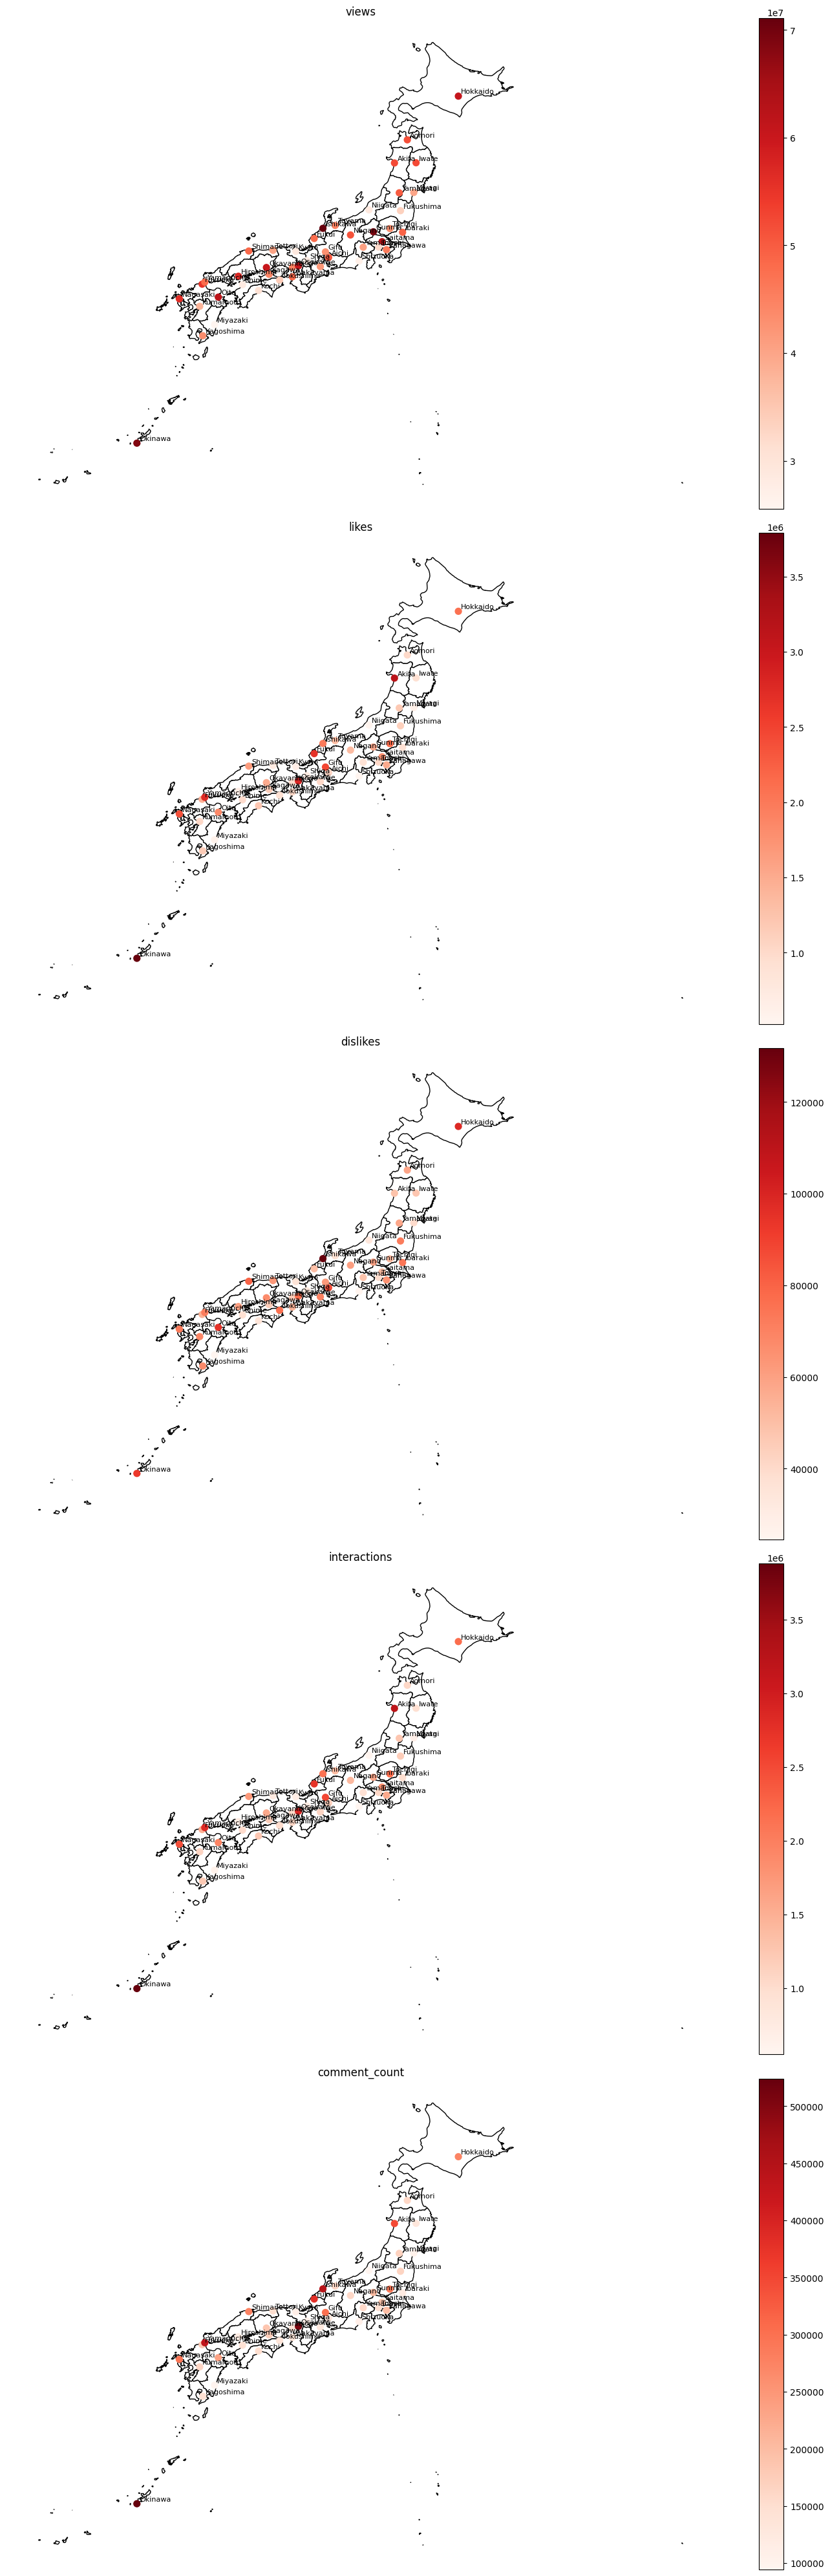

In [25]:
get_map_stats(jp, 'japan')